## MNIST Handwritten Digits Recognition

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn import preprocessing, model_selection, linear_model, pipeline, ensemble, svm, decomposition, manifold, tree, dummy, metrics
from tensorflow import keras
from custom_objects import decorators

### Getting Data

In [147]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [148]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

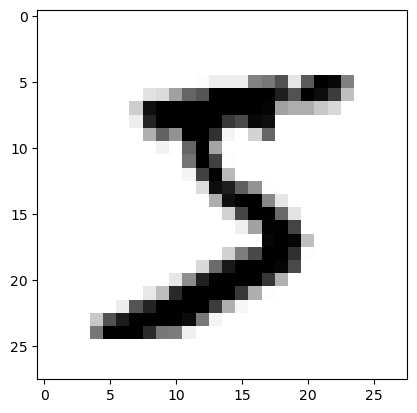

In [114]:
plt.imshow(X_train[0], cmap='binary')

In [115]:
# List the first item of each class
def list_distinct(X, y):
    distinct_items = []
    for i in range(10):
        distinct_items.append(X[y==i][0])
    return distinct_items

In [116]:
# Plot all distinct images
def plot_grid(items, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2))
    for item, class_, axis in zip(items, range(0,10), axes.flat):
        axis.imshow(item, cmap='binary')
        axis.set_title(class_)
        axis.axis('off')

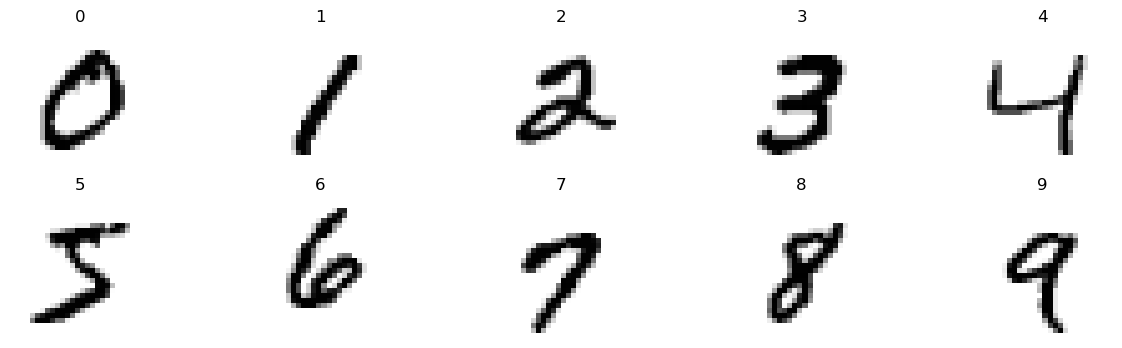

In [117]:
plot_grid(list_distinct(X_train, y_train))

In [118]:
X_train[4]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

### Preprocessing
* Flattening
* Normalization

In [119]:
# Define the function to flatten images
@decorators.sklearn_transformer
def Flatten(X, y=None):
    n = X.shape[0]
    b = X.shape[1:]
    return X.reshape(n, np.prod(b))

In [120]:
# Initial pipeline for flattening and normalization
pre_pipeline = pipeline.Pipeline([('flatten', Flatten),
                                  ('scaler', preprocessing.MinMaxScaler())])

In [121]:
X_train_prep = pre_pipeline.fit_transform(X_train)

In [122]:
X_train_prep.shape, X_train_prep.max()

((60000, 784), 1.0)

#### Visualizing High Dimensional Data

In [123]:
tsne = manifold.TSNE(n_components=2, random_state=42, method='barnes_hut') 

X_viz = tsne.fit_transform(X_prep)

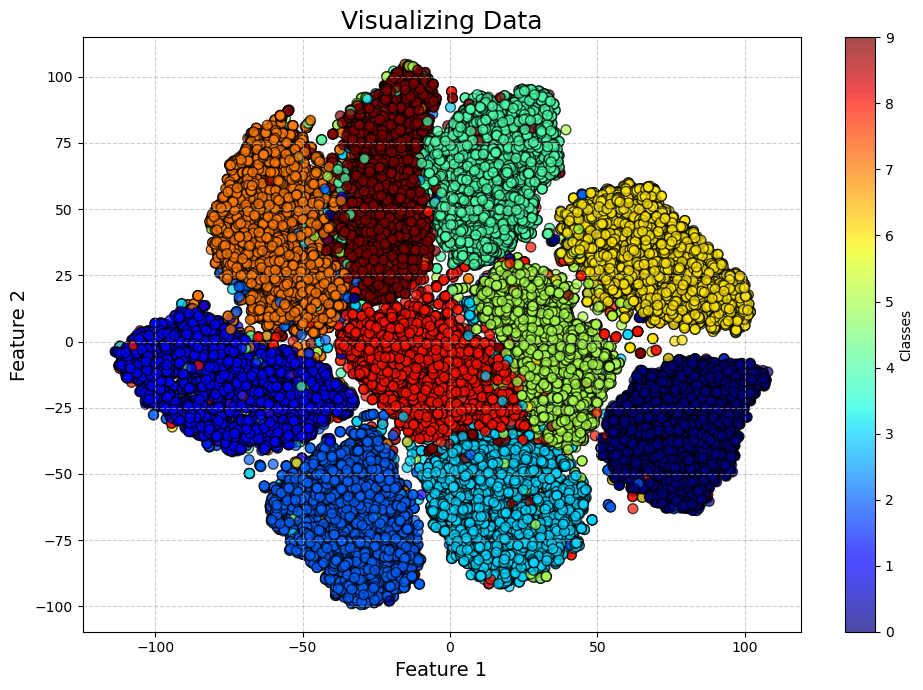

In [124]:
plt.figure(figsize=(10, 7)) 
plt.scatter(X_viz[:, 0], X_viz[:, 1], c=y_train, cmap='jet', edgecolor='k', alpha=0.7, s=50)  
plt.title('Visualizing Data', fontsize=18)  
plt.xlabel('Feature 1', fontsize=14)  
plt.ylabel('Feature 2', fontsize=14)  
plt.colorbar(label='Classes')  
plt.grid(True, linestyle='--', alpha=0.6) 
plt.tight_layout()  
plt.show()

In [125]:
def plot_digits(X, y, min_distance=0.04, n_points=5000, images=None, figsize=(13, 10)):
    
    # Shape compatibility and normalization
    X, y = X[:n_points], y[:n_points]
    X = preprocessing.MinMaxScaler().fit_transform(X)
    
    
    # This array stores all the plotted digit images (plus a faraway point to begin with)
    neighbors = np.array([[10., 10.]])
    
    # Scatter plot all points
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X[y == digit, 0], X[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    
    # Plot actual digits
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is not None:
                images = images[:n_points]
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary", zoom=0.4),
                                          image_coord)
                ax.add_artist(imagebox)

# Code taken from Aurelion Geron's Hands-on ML Book

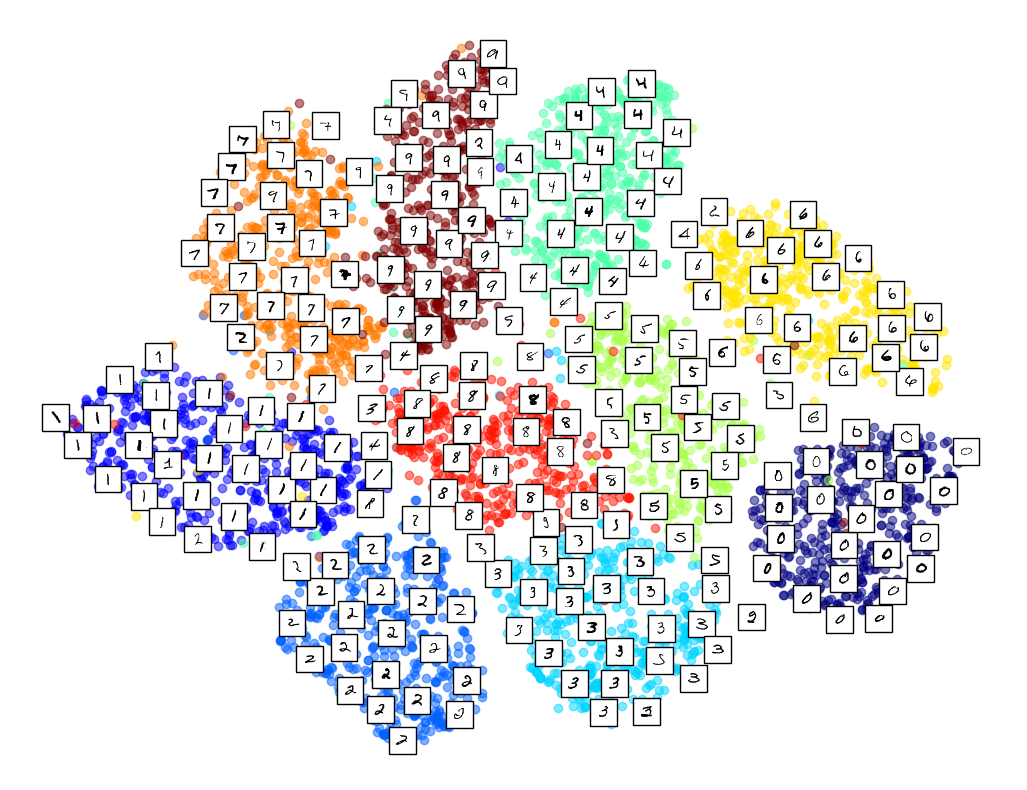

In [126]:
plot_digits(X_viz, y_train, images=X_train)

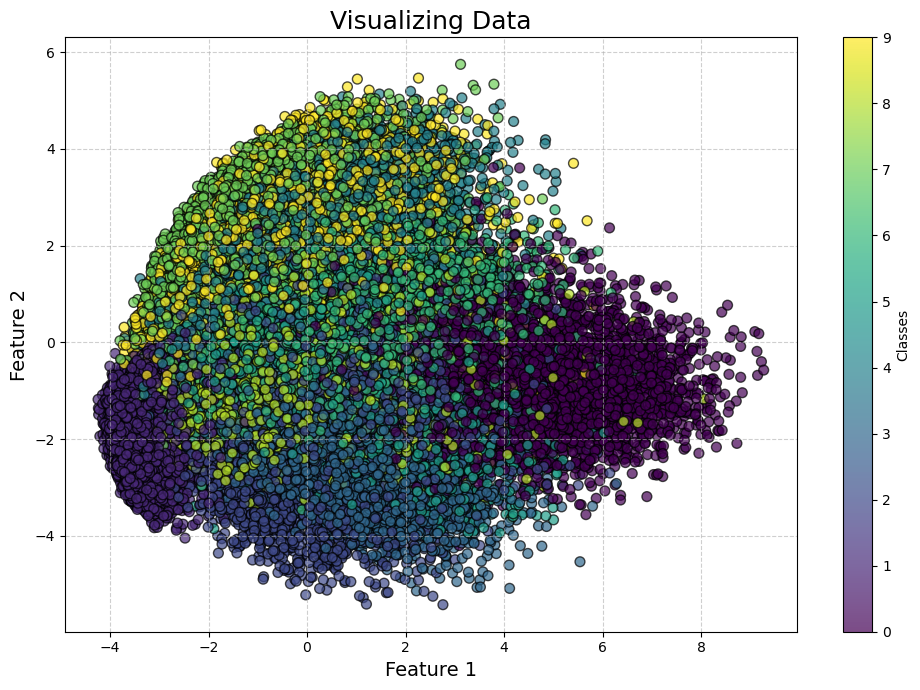

In [127]:
pca_two = decomposition.PCA(n_components=2)
X_viz_pca = pca_two.fit_transform(X_prep)

plt.figure(figsize=(10, 7))
plt.scatter(X_viz_pca[:, 0], X_viz_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', alpha=0.7, s=50)
plt.title('Visualizing Data', fontsize=18)
plt.xlabel('Feature 1', fontsize=14)
plt.ylabel('Feature 2', fontsize=14)
plt.colorbar(label='Classes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Dimensionality Reduction

In [128]:
pca = decomposition.PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_train_prep)

X_pca.shape

(60000, 154)

**Final Pipeline and Validation Set**

In [149]:
prep_pipe = pipeline.Pipeline([('flatten', Flatten),
                               ('scaler', preprocessing.StandardScaler())])

X_train_prep = prep_pipe.fit_transform(X_train)
X_test_prep = prep_pipe.transform(X_test)

In [151]:
X_train_prep, X_val_prep, y_train, y_val = model_selection.train_test_split(X_train_prep, y_train, train_size=50000, random_state=42)

In [152]:
X_train_prep.shape, X_val_prep.shape

((50000, 784), (10000, 784))

**Balanced Labels**

In [132]:
distinct = {}

for label in np.unique(y_train):
    distinct.update({label:np.count_nonzero(y_train==label)/len(y_train)})

In [133]:
def classes_bar(y):
    distinct = {}
    for label in np.unique(y):
        distinct.update({label:np.count_nonzero(y==label)/len(y)})

    x_axis = list(distinct.keys())
    y_axis = list(distinct.values())
    plt.bar(x_axis, y_axis)

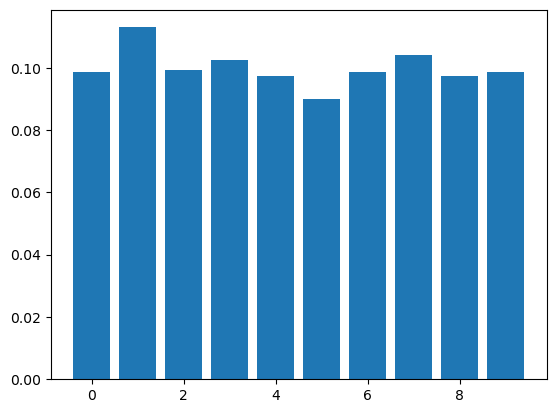

In [134]:
classes_bar(y_train)

### Binary Classification

In [135]:
y_binary_train = np.int64(y_train==9)
y_binary_val = np.int64(y_val==9)
y_binary_test = np.int64(y_test==9)
np.unique(y_binary_train)

array([0, 1])

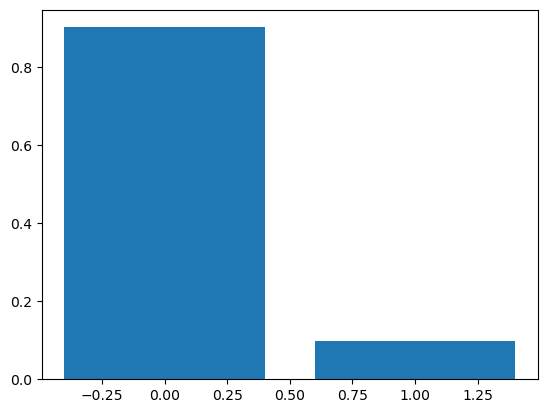

In [136]:
classes_bar(y_binary_train)

**Dummy Classifier and Importance of Metric**

In [137]:
dummy_clf = dummy.DummyClassifier(strategy='constant', constant=0)
dummy_clf.fit(X_train_prep, y_binary_train)

DummyClassifier(constant=0, strategy='constant')

In [138]:
y_train_pred = dummy_clf.predict(X_train_prep)
metrics.accuracy_score(y_binary_train, y_train_pred)

0.90122

In [139]:
print(metrics.classification_report(y_binary_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     45061
           1       0.00      0.00      0.00      4939

    accuracy                           0.90     50000
   macro avg       0.45      0.50      0.47     50000
weighted avg       0.81      0.90      0.85     50000


/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

**Gradient Descent**

In [141]:
X_train_prep.shape

(50000, 28, 28)

In [ ]:
def clf_report(estimator, X_train=X_train_prep, y_train=y_binary_train, X_val=X_val_prep, y_val=y_binary_val):
    y_train_pred = estimator.predict(X_train)
    y_val_pred = estimator.predict(X_val)
    val_score = metrics.classification_report(y_val, y_val_pred)
    train_score = metrics.classification_report(y_train, y_train_pred)
    print(f'Train: {train_score}\n{"-"*80}\nValid: {val_score}')

In [153]:
sgdc = linear_model.SGDClassifier()
sgdc.fit(X_train_prep, y_binary_train)
clf_report(sgdc, X_train_prep, y_binary_train, X_val_prep, y_binary_val)

Train:               precision    recall  f1-score   support

           0       0.98      0.99      0.98     45061
           1       0.85      0.78      0.81      4939

    accuracy                           0.96     50000
   macro avg       0.91      0.88      0.90     50000
weighted avg       0.96      0.96      0.96     50000

--------------------------------------------------------------------------------
Valid:               precision    recall  f1-score   support

           0       0.97      0.98      0.98      8990
           1       0.83      0.77      0.80      1010

    accuracy                           0.96     10000
   macro avg       0.90      0.87      0.89     10000
weighted avg       0.96      0.96      0.96     10000


In [154]:
log_reg = linear_model.LogisticRegression(solver='lbfgs', penalty='l2', C=1.0, fit_intercept=True, max_iter=500, multi_class='auto', warm_start=False, n_jobs=None, l1_ratio=None)

log_reg.fit(X_train_prep, y_binary_train)

LogisticRegression(max_iter=500)

In [155]:
clf_report(log_reg, X_train_prep, y_binary_train, X_test_prep, y_binary_test)

Train:               precision    recall  f1-score   support

           0       0.98      0.99      0.98     45061
           1       0.86      0.81      0.83      4939

    accuracy                           0.97     50000
   macro avg       0.92      0.90      0.91     50000
weighted avg       0.97      0.97      0.97     50000

--------------------------------------------------------------------------------
Valid:               precision    recall  f1-score   support

           0       0.98      0.98      0.98      8991
           1       0.84      0.82      0.83      1009

    accuracy                           0.97     10000
   macro avg       0.91      0.90      0.91     10000
weighted avg       0.97      0.97      0.97     10000


#### Visualizing Errors

In [159]:
X_train_prep = np.r_[X_train_prep, X_val_prep]
y_binary_train = np.r_[y_binary_train, y_binary_val]
y_train = np.r_[y_train, y_val]

In [166]:
y_dec_scores = model_selection.cross_val_predict(sgdc, X_train_prep, y_binary_train, cv=4, method='decision_function')

In [167]:
y_dec_scores[:5]

array([ -26.48476408, -256.55122565, -853.42535527, -446.98490124,
        -80.12829354])

**Precision-Recall Curve**

In [168]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_binary_train, y_dec_scores)
precisions.shape, recalls.shape, thresholds.shape

((60001,), (60001,), (60000,))

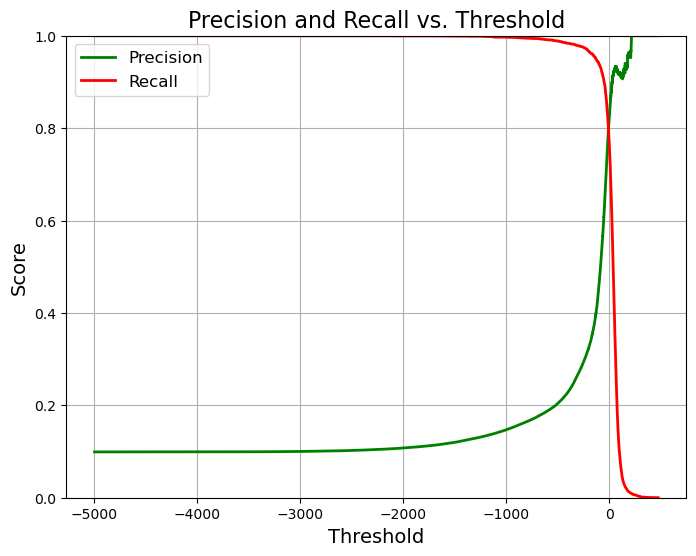

In [180]:
def plot_PR_curve(precisions, recalls, thresholds, with_thresholds=True):
    plt.figure(figsize=(8, 6)) 
    if with_thresholds:
        plt.plot(thresholds, precisions[:-1], label="Precision", linewidth=2, c='green')  
        plt.plot(thresholds, recalls[:-1], label="Recall", linewidth=2, c='red')
        plt.title("Precision and Recall vs. Threshold", fontsize=16)
        plt.xlabel("Threshold", fontsize=14)
        plt.ylabel("Score", fontsize=14)
        plt.legend(loc="best", fontsize=12)
    else:
        plt.plot(precisions, recalls)
        plt.title("Precision vs Recall", fontsize=16)
        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)

    
    plt.grid(True)  
    plt.ylim(0, 1) 

    plt.show()


plot_PR_curve(precisions, recalls, thresholds)

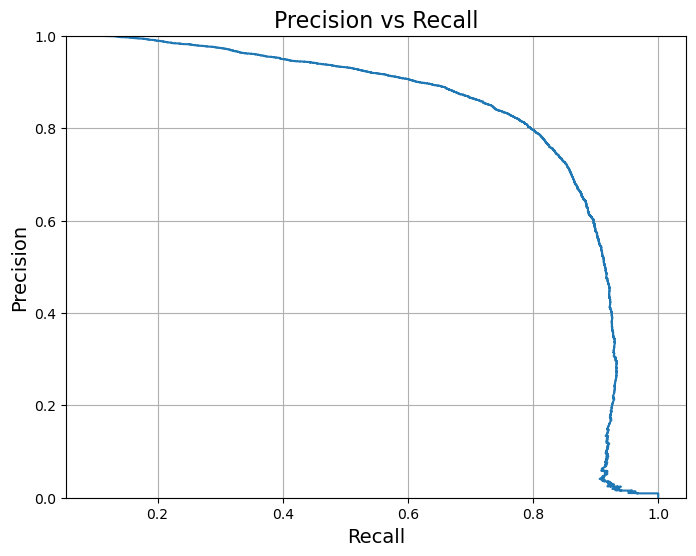

In [181]:
plot_PR_curve(precisions, recalls, thresholds, with_thresholds=False)

**ROC Curve**

In [182]:
fpr, tpr, thresholds = metrics.roc_curve(y_binary_train, y_dec_scores)

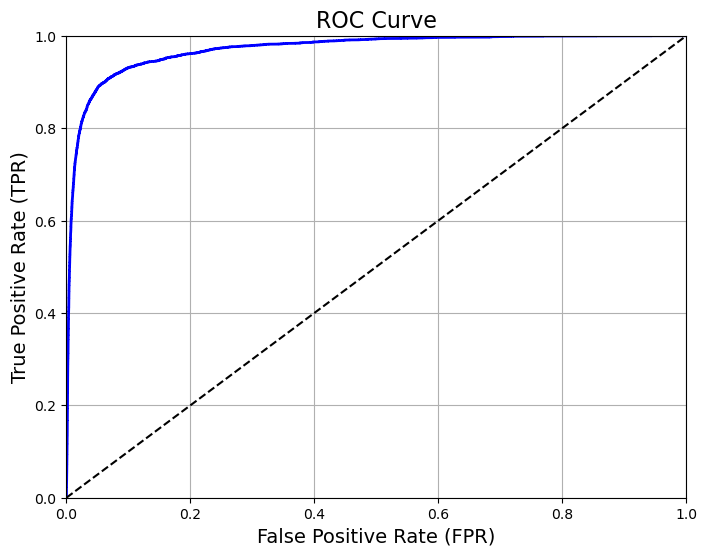

In [185]:
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, c='blue')
    plt.plot([0, 1], [0, 1], 'k--')

    plt.title("ROC Curve", fontsize=16)
    plt.xlabel("False Positive Rate (FPR)", fontsize=14)
    plt.ylabel("True Positive Rate (TPR)", fontsize=14)
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.show()

plot_roc_curve(fpr, tpr)

In [189]:
def plot_classifier_curves(classifiers, X_val, y_val, plot_type='pr'):
    plt.figure(figsize=(10, 8))

    for clf in classifiers:
       
        if hasattr(clf, "decision_function"):
            y_scores = clf.decision_function(X_val)
        else:
            y_scores = clf.predict_proba(X_val)[:, 1]

        if plot_type == 'pr':
            
            precision, recall, thresholds = metrics.precision_recall_curve(y_val, y_scores)
            plt.plot(recall, precision, lw=2, label=f'{clf.__class__.__name__}')
            plt.xlabel('Recall', fontsize=14)
            plt.ylabel('Precision', fontsize=14)
            plt.title('Precision-Recall Curve', fontsize=16)

        elif plot_type == 'pr_threshold':
            
            precision, recall, thresholds = metrics.precision_recall_curve(y_val, y_scores)
            plt.plot(thresholds, precision[:-1], "b--", label=f'Precision {clf.__class__.__name__}')
            plt.plot(thresholds, recall[:-1], "g-", label=f'Recall {clf.__class__.__name__}')
            plt.xlabel('Threshold', fontsize=14)
            plt.ylabel('Score', fontsize=14)
            plt.title('Precision-Recall vs. Threshold', fontsize=16)

        elif plot_type == 'roc':
            
            fpr, tpr, _ = metrics.roc_curve(y_val, y_scores)
            roc_auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{clf.__class__.__name__} (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlabel('False Positive Rate', fontsize=14)
            plt.ylabel('True Positive Rate', fontsize=14)
            plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

    plt.legend(loc="best", fontsize=12)
    plt.grid(True)
    plt.xlim([-0.02, 1.02])
    plt.ylim([0, 1.05])

    plt.show()


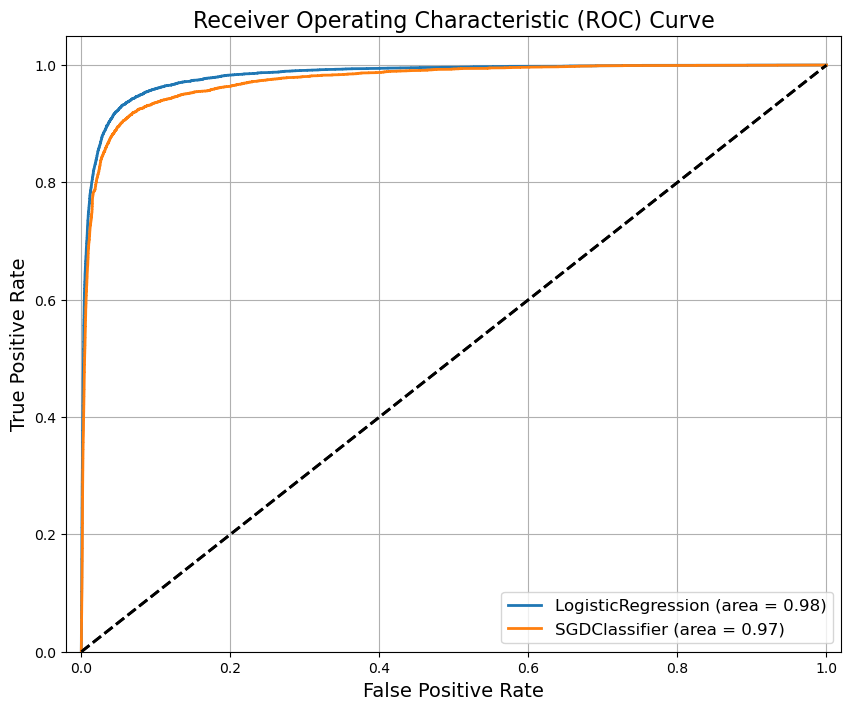

In [190]:
plot_classifier_curves([log_reg, sgdc], X_train_prep, y_binary_train, plot_type='roc')

### Multiclass Classification

In [191]:
dt_clf = tree.DecisionTreeClassifier()  # Decision Tree (zero expectations from this lol)
lin_svc = svm.LinearSVC()               # Linear SVM Classifier
sfmx_clf = linear_model.LogisticRegression(multi_class='multinomial')    # Softmax Regression
rf_clf = ensemble.RandomForestClassifier()                      # Random Forest Classifier with 100 trees
sgd_clf = linear_model.SGDClassifier()                          # SGD Classifier

shortlist = [dt_clf, lin_svc, sfmx_clf, rf_clf, sgd_clf]

In [192]:
# MIGHT TAKE 15 MINUTES TO RUN
initial_run_scores = {}

for model in shortlist:
    score = model_selection.cross_val_score(model, X_train_prep, y_train, cv=3, n_jobs=-1)
    initial_run_scores.update({model: score.mean()})
    print(model, score)
    

DecisionTreeClassifier() [0.8596  0.85865 0.8595 ]


/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(

LinearSVC() [0.8996  0.9014  0.90025]


/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

LogisticRegression(multi_class='multinomial') [0.9114  0.90965 0.9102 ]
RandomForestClassifier() [0.96485 0.96605 0.9655 ]
SGDClassifier() [0.9005 0.8997 0.8981]


**Feature Importances**

In [194]:
rf_clf = ensemble.RandomForestClassifier(n_estimators=50)
rf_clf.fit(X_train_prep, y_train)

RandomForestClassifier(n_estimators=50)

Text(0.5, 1.0, 'Feature Importances')

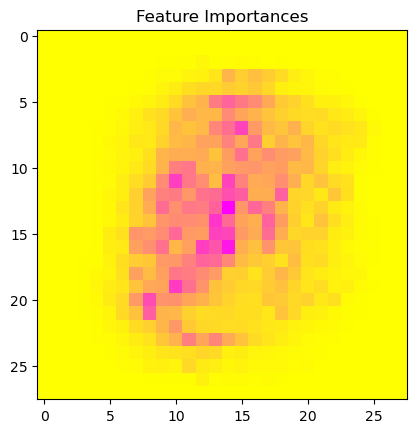

In [195]:
feature_imp_matrix = rf_clf.feature_importances_.reshape(28,28)
plt.imshow(feature_imp_matrix, cmap='spring_r')
plt.title('Feature Importances')

**Error Analysis**

In [203]:
y_pred_rf = model_selection.cross_val_predict(rf_clf, X_train_prep, y_train, cv=3, n_jobs=-1)
y_pred_rf

array([9, 5, 1, ..., 9, 8, 1], dtype=uint8)

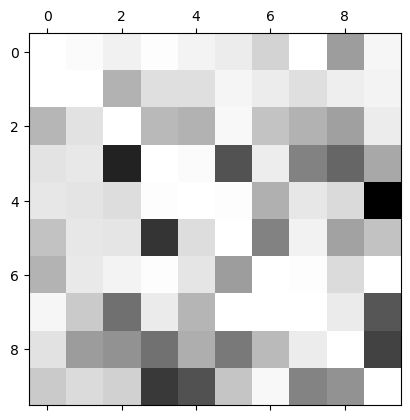

In [205]:
conf_matrix_rf = metrics.confusion_matrix(y_train, y_pred_rf)
normalized_conf_matrix_rf = conf_matrix_rf/conf_matrix_rf.sum(axis=1, keepdims=True)

np.fill_diagonal(normalized_conf_matrix_rf, 0)
plt.matshow(normalized_conf_matrix_rf, cmap='binary')

**SVM**

In [6]:
svc = svm.SVC()
score_svm = model_selection.cross_val_score(svc, X_train_prep, y_train, cv=3, n_jobs=-1)

score_svm.mean()

0.9602666666666666

In [8]:
search_space = [{'C': [0.1, 1, 10],
                 'kernel':['rbf']},
                {'C':[0.1, 1, 10],
                 'kernel':['poly'],
                 'degree':[2,3,4],
                 'coef0':[0.0, 0.2]}]

grid_search = model_selection.GridSearchCV(svc, search_space, cv=5, n_jobs=-1, scoring='accuracy', verbose=4)

In [9]:
grid_search.fit(X_train_prep, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['rbf']},
                         {'C': [0.1, 1, 10], 'coef0': [0.0, 0.2],
                          'kernel': ['poly']}],
             scoring='accuracy', verbose=4)

In [15]:
grid_search.best_params_, grid_search.best_score_

({'C': 10, 'coef0': 0.2, 'kernel': 'poly'}, 0.9782833333333334)

In [21]:
svm_final = svm.SVC(**grid_search.best_params_)

bag_clf = ensemble.BaggingClassifier(estimator=svm_final, n_estimators=10, warm_start=True, n_jobs=-1, random_state=42)

In [22]:
bag_clf.fit(X_train_prep, y_train)

BaggingClassifier(estimator=SVC(C=10, coef0=0.2, kernel='poly'), n_jobs=-1,
                  random_state=42, warm_start=True)

In [42]:
bag_clf.score(X_test_prep, y_test)

0.9811


Kartik Kumar
For more projects, please visit [My GithHub Page](https://github.com/ryuukkk)